In [1]:
import numpy as np
import pandas as pd
import ast
import json
import urllib
import urllib2
import itertools
from cStringIO import StringIO
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import statsmodels.formula.api as smf
from sklearn.cluster import k_means
from scipy.cluster.vq import whiten
from scipy.cluster.vq import kmeans2
from math import sqrt
%matplotlib inline

In [2]:
SQL_SOURCE = 'https://htv210.cartodb.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [3]:
dischargeQuery = '''
SELECT *
FROM nyc_discharge_2013
WHERE ccs_diagnosis_description = 'ASTHMA'
'''
try:
    dischargeStream = queryCartoDB(dischargeQuery, format='CSV')
    discharge       = pd.read_csv(dischargeStream)
    discharge.head()
except:
    print 'The data queried through, doesnt contain any data to parse. Please restart or try again later'
    pass

In [4]:
facilityQuery = '''
SELECT *
FROM nyc_facilities
'''
facilityStream = queryCartoDB(facilityQuery, format='GeoJSON')
facilityData   = json.loads(facilityStream.read())
facilities     = gpd.GeoDataFrame.from_features(facilityData['features'])
facilities.head()

,cartodb_id,cooperator_address,cooperator_address_2,cooperator_city,cooperator_name,cooperator_state,cooperator_zip_code,description,facility_address_1,facility_address_2,...,operator_address_1,operator_address_2,operator_city,operator_name,operator_state,operator_zip_code,ownership_type,regional_office,regional_office_id,short_description
0,2106,,,,,New York,NaN,Diagnostic and Treatment Center,1110 Pennsylvania Avenue,,...,1110 Pennsylvania Avenue,,Brooklyn,PALA Community Care LLC,New York,11207,LLC,Metropolitan Area Regional Office - New York City,5,DTC
1,2311,,,,,New York,NaN,Diagnostic and Treatment Center,468 Lafayette Avenue,,...,468 Lafayette Avenue,,Brooklyn,"Medcare, LLC",New York,11205,LLC,Metropolitan Area Regional Office - New York City,5,DTC
2,643,,,,,New York,NaN,Diagnostic and Treatment Center,1776 Clay Avenue,,...,1776 Clay Avenue,,Bronx,P R O M E S A Inc,New York,10457,Not for Profit Corporation,Metropolitan Area Regional Office - New York City,5,DTC
3,805,,,,,New York,NaN,Residential Health Care Facility - SNF,214 West Houston Street,,...,"120 Broadway, Suite 2840",,New York,Village Center for Care,New York,10271,Not for Profit Corporation,Metropolitan Area Regional Office - New York City,5,NH
4,1903,,,,,New York,NaN,Diagnostic and Treatment Center,2781 Third Ave,,...,2781 Third Avenue,,Bronx,Third Avenue Open MRI Inc,New York,10455,Business Corporation,Metropolitan Area Regional Office - New York City,5,DTC


In [5]:
#facilities['description']

In [6]:
zipcodeQuery = '''
SELECT *
FROM nyc_zipcode_highway
'''
zipcodeStream = queryCartoDB(zipcodeQuery, format='GeoJSON')
zipcodeData   = json.loads(zipcodeStream.read())
zipcodes      = gpd.GeoDataFrame.from_features(zipcodeData['features'])
zipcodes.head()

,cartodb_id,geometry,highway_length,zipcode
0,1,"(POLYGON ((-74.194287 40.608911, -74.194929 40...",23.486470,10314
1,2,"(POLYGON ((-73.980886 40.75927, -73.9804259999...",0.000000,10112
2,3,"(POLYGON ((-74.011674 40.709687, -74.012646 40...",1.447405,10048
3,4,"(POLYGON ((-73.97282 40.75587, -73.973276 40.7...",0.000000,10171
4,5,"(POLYGON ((-73.97373500000001 40.754619, -73.9...",0.000000,10172


In [7]:
zipcodes['zipcode'] = map(np.int64, zipcodes['zipcode'] )

In [8]:
facilities.columns

Index([                  u'cartodb_id',           u'cooperator_address',
               u'cooperator_address_2',              u'cooperator_city',
                    u'cooperator_name',             u'cooperator_state',
                u'cooperator_zip_code',                  u'description',
                 u'facility_address_1',           u'facility_address_2',
                      u'facility_city',              u'facility_county',
               u'facility_county_code',          u'facility_fax_number',
                        u'facility_id',            u'facility_latitude',
                  u'facility_location',           u'facility_longitude',
                      u'facility_name',           u'facility_open_date',
              u'facility_phone_number',               u'facility_state',
                   u'facility_website',            u'facility_zip_code',
                           u'geometry',        u'main_site_facility_id',
                     u'main_site_name', u'operating

In [9]:
# parks = gpd.GeoDataFrame.from_file("DPR_ParksProperties_001/DPR_ParksProperties_001.shp")
# print parks.columns

# parks.head()

In [10]:
#finding distinct diagnosis
print set(discharge['ccs_diagnosis_description'])

set(['ASTHMA'])


In [11]:
#Cross-referecincing offline with geopadas without the where command in sql
#discharge_asthma = discharge[discharge['ccs_diagnosis_description']=='ASTHMA']

In [12]:
asthma_count =  discharge.groupby(['facility_id']).count()['ccs_diagnosis_description']
# the groupby result gives a pandas series

In [13]:
asthma_count = (pd.DataFrame(asthma_count))  # Converting Pandas Series to Pandas DataFrame

In [14]:
print len(discharge)
print len(asthma_count)
asthma = asthma_count # I am making a seperate dataframe as we have to make maps for the values of zipcodes all through and we 
# a I want to display a dataframe with those 5 facilities also without slicing the above one
print len(asthma)

22910
50
50


In [15]:
#Normalizing it using (X-mean)/Std.Dev
#So we need to calculate mean and std. dev

asthma_mean = np.mean(asthma_count['ccs_diagnosis_description'])
asthma_sd = np.std(asthma_count['ccs_diagnosis_description'])

In [16]:
asthma_count['ccs_diagnosis_description'] = (asthma_count['ccs_diagnosis_description'] - asthma_mean)/asthma_sd

In [17]:
asthma_count = asthma_count.sort(['ccs_diagnosis_description'], ascending = False)


c:\users\priya\anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [18]:
asthma_count['facility_id'] = asthma_count.index
asthma = asthma_count
asthma.index = range(len(asthma))
asthma_count = asthma_count[:5]
asthma_count.index = range(len(asthma_count))
asthma_count

,ccs_diagnosis_description,facility_id
0,3.901833,1172
1,3.649003,1169
2,1.645596,1301
3,1.269099,1165
4,1.186654,1178


In [19]:
top_5 = list(asthma_count.facility_id[:5])
top_5 #facilities 

[1172, 1169, 1301, 1165, 1178]

In [20]:
# merging with full_facilites data 
facilities_full = pd.merge(facilities,asthma, on='facility_id' )

In [21]:
#facilities_full['zipcode'] = facilities_full['operator_zip_code']
facilities_full.rename(columns={'facility_zip_code':'zipcode'}, inplace=True)
# we can rename the operator zip code to zipcode as there will be a lot of merging required 
# so it's better to make it a standard

In [22]:
#asthma['facility_id'] = asthma.index

In [23]:
facilities_5 = pd.merge(facilities,asthma_count, on='facility_id' )

In [24]:
facilities_5['zipcode'] = facilities_5['facility_zip_code']

In [25]:
facilities_5['zipcode'] = map(np.int64, facilities_5['zipcode'] )

In [26]:
# Getting the x and y co-ordinate, this code has been taken from GITHUB
# https://github.com/geopandas/geopandas/issues/246
# Getting all the data for those 5 facilities in both dataframes
zips = pd.merge(zipcodes,facilities_5, on = 'zipcode')
x = zips['geometry_y'].apply(lambda p: p.x)
y = zips['geometry_y'].apply(lambda p: p.y)


### Method 2 
There are other ways also which Prof. Federica had implied in her .ipynb , using a function- 

In [27]:
## zips.rename(columns={'geometry_y':'geometry'}, inplace=True)
# print zipcodes.crs
#merging the full data with zipcdes and facility id now
zip_full = facilities_full[['zipcode','facility_id']]

c:\users\priya\anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


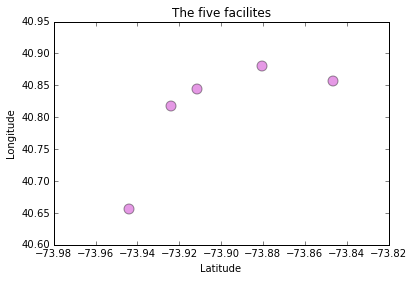

In [28]:
plt.scatter(x=x, y=y, c='m', alpha=0.4,s=100)
plt.title('The five facilites')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

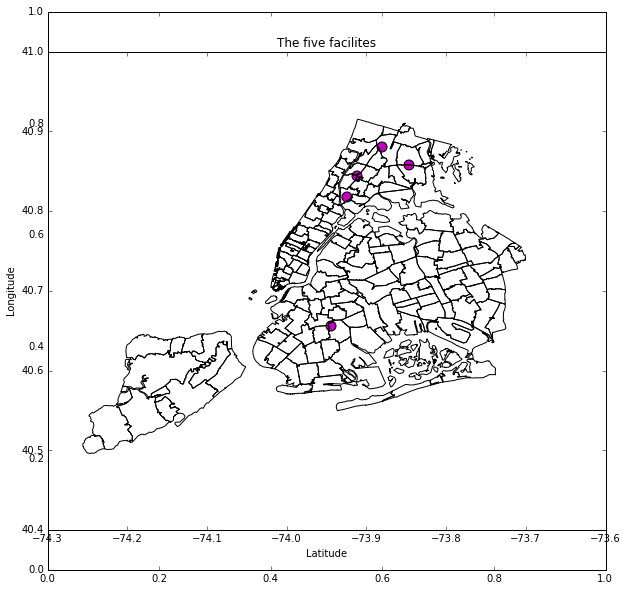

In [29]:
f, ax = plt.subplots(1, figsize=(10,10))

zipcodes.plot(alpha=0)
plt.scatter(x=x, y=y, c='m', alpha=1,s=100)
#http://geoffboeing.com/2014/09/visualizing-summer-travels-part-6-projecting-spatial-data-python/
#Though this was a simple scatter, I couldn't get it somehow so I understood it from the code 
#and example in the above blog
plt.title('The five facilites')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

plt.show()

In [30]:

zips[['zipcode','facility_name','facility_id','ccs_diagnosis_description','highway_length']]

,zipcode,facility_name,facility_id,ccs_diagnosis_description,highway_length
0,10467,Montefiore Medical Center - Henry & Lucy Moses...,1169,3.649003,19.172015
1,10451,Lincoln Medical & Mental Health Center,1172,3.901833,7.914185
2,10457,Bronx-Lebanon Hospital Center - Concourse Divi...,1178,1.186654,5.017199
3,10461,Jacobi Medical Center,1165,1.269099,18.102258
4,11203,Kings County Hospital Center,1301,1.645596,2.212840


In [31]:
data = zips[['zipcode','facility_name','facility_id','ccs_diagnosis_description','highway_length']]

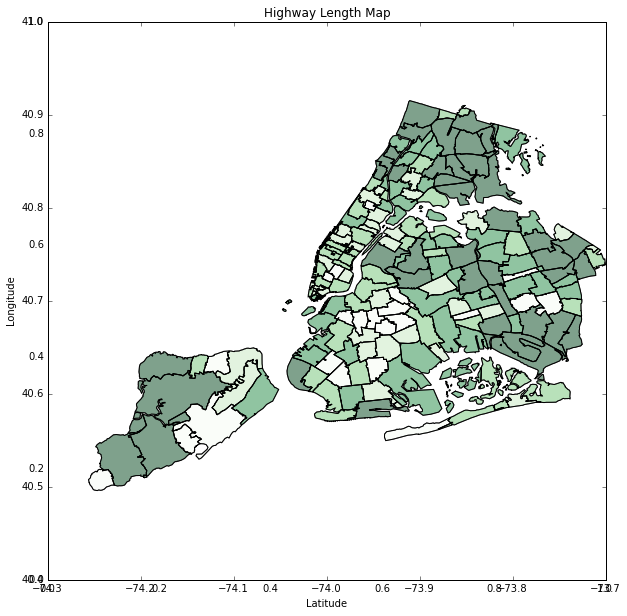

In [32]:
f, ax = plt.subplots(1,figsize=(10,10))
zipcodes.plot(column='highway_length', scheme='Quantiles', colormap='Greens')
#Taking colorblind into consideration from http://colorbrewer2.org/
plt.title('Highway Length Map')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

## Beginning with the Second regressor - 
#### I am using 311 data for the year 2013.

In [33]:
complaints = pd.read_csv('https://www.dropbox.com/s/f09vb9tds170xml/311_2013.csv?raw=1')

c:\users\priya\anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (8,17,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [34]:
complaints.columns

Index([u'Unique Key', u'Created Date', u'Closed Date', u'Agency',
       u'Agency Name', u'Complaint Type', u'Descriptor', u'Location Type',
       u'Incident Zip', u'Incident Address', u'Street Name', u'Cross Street 1',
       u'Cross Street 2', u'Intersection Street 1', u'Intersection Street 2',
       u'Address Type', u'City', u'Landmark', u'Facility Type', u'Status',
       u'Due Date', u'Resolution Description',
       u'Resolution Action Updated Date', u'Community Board', u'Borough',
       u'X Coordinate (State Plane)', u'Y Coordinate (State Plane)',
       u'Park Facility Name', u'Park Borough', u'School Name',
       u'School Number', u'School Region', u'School Code',
       u'School Phone Number', u'School Address', u'School City',
       u'School State', u'School Zip', u'School Not Found',
       u'School or Citywide Complaint', u'Vehicle Type',
       u'Taxi Company Borough', u'Taxi Pick Up Location',
       u'Bridge Highway Name', u'Bridge Highway Direction', u'Road Ramp',

In [35]:
complaints.rename(columns={'Incident Zip':'zipcode'}, inplace=True)
complaints = complaints[(complaints['zipcode']>10000) & (complaints['zipcode']<12000)]

In [36]:
len(complaints)

472289

In [37]:
# Taken from the instruction ipynb for us to follow
validcomplaints = ['UNSANITARY CONDITION','Dirty Conditions', 'Sewer',
                   'Hazardous Material','Construction',
                   'Indoor Air Quality','Indoor Sewage','Air Quality',
                   'HEATING','Industrial Waste','Mold','Asbestos',
                   'Sweeping/Missed-Inadequate','Smoking',
                   'Non-Residential Heat','Lead','Standing Water',
                    'Water Quality','Unsanitary Animal Facility',
                   'PAINT - PLASTER','GENERAL CONSTRUCTION']

In [38]:
df = complaints[(complaints['Complaint Type'].isin(validcomplaints)) &
                (complaints['zipcode']>10000) & (complaints['zipcode']<12000)]

In [39]:
#c = pd.DataFrame()
# Due to recurring occurences of NaN errors while merging I decided to go to the level of lists to get all the data
count = list(complaints.groupby(['zipcode']).count()['Unique Key'])
zipco = list(complaints.groupby(['zipcode']).count().index)
print len(zipco),len(count)
new_df = pd.DataFrame({'zipcode':zipco,'count':count})
new_df

#c = complaints.loc[(complaints['zipcode'].isin(
count_n = list(df.groupby(['zipcode']).count()['Unique Key'])
print count_n

zipco_n = list(df.groupby(['zipcode']).count()['Unique Key'].index)

print len(zipco_n),len(count_n)

new_df1 = pd.DataFrame({'count_n':count_n,'zipcode':zipco_n})


new_df2 = pd.merge(new_df1,new_df,on='zipcode')

275 275
[316, 825, 766, 39, 31, 17, 65, 1133, 328, 896, 508, 302, 533, 588, 119, 183, 632, 2, 387, 308, 447, 647, 1578, 945, 1765, 544, 1378, 1301, 2757, 2580, 2001, 1677, 911, 544, 603, 134, 702, 2720, 28, 318, 5, 270, 1, 543, 20, 2, 559, 285, 388, 649, 349, 592, 38, 151, 128, 286, 279, 477, 1384, 3298, 3865, 879, 1228, 2952, 3534, 4210, 1698, 1986, 943, 2044, 2702, 128, 409, 1730, 4306, 4082, 889, 557, 220, 2226, 679, 417, 134, 5, 19, 84, 24, 522, 401, 495, 517, 537, 460, 3, 505, 2445, 923, 544, 935, 2326, 1971, 874, 1369, 952, 2458, 3080, 1122, 883, 2290, 486, 1528, 968, 1034, 2663, 582, 889, 581, 3025, 5003, 226, 1033, 1850, 368, 383, 2395, 742, 1381, 1047, 1201, 1636, 98, 1, 265, 552, 874, 190, 276, 320, 87, 257, 107, 58, 273, 233, 77, 521, 968, 377, 149, 836, 1054, 509, 748, 901, 399, 266, 1370, 230, 641, 367, 310, 297, 287, 400, 445, 454, 412, 387, 281, 378, 120, 292, 197, 324, 10, 846, 655, 695, 634, 302, 1167, 343, 201, 561, 9]
185 185


In [40]:
len(new_df2)

185

In [41]:
new_df2['normalized'] = new_df2['count_n']/new_df2['count']

In [42]:
new_df2

,count_n,zipcode,count,normalized
0,316,10001,2273,0.139023
1,825,10002,3601,0.229103
2,766,10003,3693,0.207419
3,39,10004,514,0.075875
4,31,10005,591,0.052453
5,17,10006,265,0.064151
6,65,10007,832,0.078125
7,1133,10009,3291,0.344272
8,328,10010,1696,0.193396
9,896,10011,3295,0.271927


In [43]:
ndf = new_df2[['zipcode','normalized']]
ndf
# new dataframe just for testing purposes, and not to lose values of the new_df2 when needed for further development

,zipcode,normalized
0,10001,0.139023
1,10002,0.229103
2,10003,0.207419
3,10004,0.075875
4,10005,0.052453
5,10006,0.064151
6,10007,0.078125
7,10009,0.344272
8,10010,0.193396
9,10011,0.271927


In [44]:
data = pd.merge(data,ndf, on='zipcode')


In [45]:
#If you run the above cell more than once it will result in redundant merging with renamed columns, hence I have split the cell
data

,zipcode,facility_name,facility_id,ccs_diagnosis_description,highway_length,normalized
0,10467,Montefiore Medical Center - Henry & Lucy Moses...,1169,3.649003,19.172015,0.537779
1,10451,Lincoln Medical & Mental Health Center,1172,3.901833,7.914185,0.513353
2,10457,Bronx-Lebanon Hospital Center - Concourse Divi...,1178,1.186654,5.017199,0.557237
3,10461,Jacobi Medical Center,1165,1.269099,18.102258,0.302437
4,11203,Kings County Hospital Center,1301,1.645596,2.212840,0.433511


In [46]:
#Rockaway Zipcodes = 11691, 11690, 11693, 11695
#I could not find any exceptionally high values for the rockaway zipcodes, hence I didnt suppress the value with mean

In [47]:
zips = pd.merge(zips,ndf, on='zipcode')

In [48]:
with_zip_plotting = pd.merge(zipcodes, ndf, on='zipcode')
#for plotting purposes-
#when the data is merged with asthma risk, it goes down to a count of 50 from 177
#making it difficult while plotting as most of the zipcodes are absent

In [49]:
len(with_zip_plotting)

177

In [50]:
zip_full['zipcode'] = map(np.int64, zip_full['zipcode'])


c:\users\priya\anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


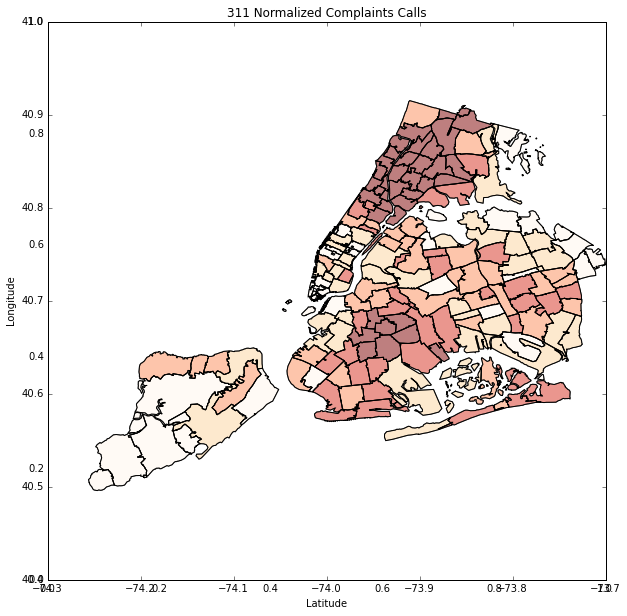

In [51]:
f, ax = plt.subplots(1,figsize=(10,10))
with_zip_plotting.plot(column='normalized', scheme='Quantiles', colormap='OrRd')
plt.title('311 Normalized Complaints Calls ')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [52]:
lm = smf.ols(formula = 'ccs_diagnosis_description ~ highway_length+normalized', data = data).fit()
print lm.summary()

                                OLS Regression Results                               
Dep. Variable:     ccs_diagnosis_description   R-squared:                       0.409
Model:                                   OLS   Adj. R-squared:                 -0.182
Method:                        Least Squares   F-statistic:                    0.6921
Date:                       Tue, 22 Dec 2015   Prob (F-statistic):              0.591
Time:                               14:35:43   Log-Likelihood:                -6.6604
No. Observations:                          5   AIC:                             19.32
Df Residuals:                              2   BIC:                             18.15
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------

c:\users\priya\anaconda2\lib\site-packages\statsmodels\stats\stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))


In [53]:
zips.columns

Index([                u'cartodb_id_x',                   u'geometry_x',
                     u'highway_length',                      u'zipcode',
                       u'cartodb_id_y',           u'cooperator_address',
               u'cooperator_address_2',              u'cooperator_city',
                    u'cooperator_name',             u'cooperator_state',
                u'cooperator_zip_code',                  u'description',
                 u'facility_address_1',           u'facility_address_2',
                      u'facility_city',              u'facility_county',
               u'facility_county_code',          u'facility_fax_number',
                        u'facility_id',            u'facility_latitude',
                  u'facility_location',           u'facility_longitude',
                      u'facility_name',           u'facility_open_date',
              u'facility_phone_number',               u'facility_state',
                   u'facility_website',            

In [54]:
zippy_full = pd.merge(zip_full,with_zip_plotting, on='zipcode')

In [55]:
len(zippy_full)

47

In [56]:
cluster_distance = pd.DataFrame()
first =[]
second=[]
dist = []
for i in range(177):
    d = 0
    dist = []
    for j in range(177):
        #if j>i:
            #print j 
        z11 = with_zip_plotting['highway_length'][i]
        z1_1 = with_zip_plotting['highway_length'][j]
        coeffh = (lm.params[1]**2)*((z11 - z1_1)**2)
            
        
        z22 = with_zip_plotting['normalized'][i]
        z2_2 = with_zip_plotting['normalized'][j]
        coeffn = (lm.params[2]**2)*((z22 - z2_2)**2)
        d = sqrt(coeffh + coeffn) 
        dist.append(d)
        first.append(i)
        second.append(j)
    cluster_distance[str(i)] = dist        
      

### Method 2
The following is another method of making the dataframe for clustering. Both seemed intuitive, though the above one has
been implemented in prior assignments. The euclidean_distance_2 dataframe is same as the euclidean_distance

In [57]:
edw = whiten(cluster_distance)
# to compare the value difference for a few values
print edw[0][1]
print cluster_distance.loc[0][1]

print np.shape(edw)
cluster_distance

whitened_cluster_distance = pd.DataFrame(edw)

1.93400352884
1.879906167
(177L, 177L)


In [58]:
whitened_cluster_distance

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,0.000000,1.934004,1.443818,3.726686,1.691690,1.474056,0.859310,3.446254,3.577947,3.785587,...,3.059858,4.332354,4.012605,2.193959,3.936329,2.536835,4.355912,3.086522,1.657073,1.277621
1,2.447450,0.000000,1.099388,3.989642,0.727822,1.677537,1.475975,3.073967,4.179231,3.673833,...,3.297947,3.426901,3.696486,1.544290,3.642075,1.869925,3.586382,2.888290,1.194312,0.713455
2,1.560967,0.939238,0.000000,2.598965,0.363454,0.439850,1.189526,1.957779,3.213724,3.099454,...,1.886652,2.662060,2.708255,0.689233,2.898812,0.997852,2.824479,1.682888,0.206100,0.735969
3,2.588464,2.189761,1.669700,0.000000,1.734613,1.562480,2.528339,0.762470,1.532287,1.735746,...,0.634425,1.347153,0.783881,1.398462,1.226956,1.288906,1.313897,0.792714,1.575073,2.157479
4,1.932882,0.657133,0.384108,2.853434,0.000000,0.838648,1.347061,2.071740,3.418694,3.148018,...,2.170770,2.614736,2.794315,0.718436,2.946590,1.021966,2.799841,1.855430,0.395705,0.717457
5,1.412668,1.270403,0.389897,2.155863,0.703430,0.000000,1.308544,1.686226,2.870274,2.905694,...,1.450539,2.510805,2.429064,0.698163,2.674121,0.933876,2.648102,1.374353,0.400727,1.008949
6,1.037984,1.408844,1.329025,4.397001,1.424109,1.649312,0.000000,3.813875,4.252724,4.164243,...,3.626777,4.581655,4.459772,2.212182,4.333956,2.623060,4.651396,3.471674,1.589315,0.692718
7,2.551695,1.798557,1.340800,0.812803,1.342555,1.302780,2.337800,0.000000,2.034030,1.942710,...,0.633171,0.918508,0.845489,0.910893,1.377990,0.725712,1.067715,0.301327,1.204179,1.867652
8,3.745633,3.457253,3.111849,2.309470,3.132326,3.135369,3.685683,2.875856,0.000000,1.209914,...,2.814252,2.977006,2.167333,3.100292,1.578885,3.110762,2.648287,2.921838,3.095507,3.374108
9,4.740924,3.635738,3.590323,3.129656,3.450502,3.797113,4.317429,3.285913,1.447414,0.000000,...,3.635992,2.772267,2.282238,3.480495,1.194940,3.465371,2.349546,3.477098,3.546988,3.783822


In [59]:
#ed = pd.DataFrame({'first':first, 'second':second, 'ed':dist})
est = k_means(whitened_cluster_distance, n_clusters=4)
with_zip_plotting['cluster'] = est[1]
est
#to see how clusters are assigned

(array([[ 1.74139606,  0.86209529,  0.79881896,  3.25054698,  0.71361219,
          1.13021328,  1.24718405,  2.59650188,  3.57967926,  3.39206979,
          3.22994113,  1.70516498,  3.70895574,  3.33502869,  2.05345528,
          1.81543601,  2.42654344,  1.13096665,  0.99066507,  1.37351395,
          0.72308934,  0.9074693 ,  1.42339899,  3.3017163 ,  1.25263231,
          1.55061971,  0.68616389,  0.84645937,  0.98512692,  0.78525964,
          3.29617112,  3.34091131,  0.80590264,  0.80375603,  1.29572357,
          1.42582864,  2.3674811 ,  0.88644222,  1.91952741,  2.62776184,
          2.04793585,  1.50592907,  1.72469589,  2.56091098,  1.72946099,
          2.56625712,  1.84052334,  0.73971181,  2.50581626,  2.43593178,
          1.85580821,  2.57978171,  2.86243616,  1.40857645,  1.26445991,
          2.86491978,  1.56016759,  2.75699125,  2.35718405,  0.9590415 ,
          1.75861602,  2.73183685,  3.09246275,  2.13077757,  2.81898152,
          2.42696977,  1.87713138,  1.

In [60]:
# df1 for testing which cluster has what values
df0 = with_zip_plotting[with_zip_plotting['cluster']==0]
df1 = with_zip_plotting[with_zip_plotting['cluster']==1]
df2 = with_zip_plotting[with_zip_plotting['cluster']==2]
#df3 = with_zip_plotting[with_zip_plotting['cluster']==3]
with_zip_plotting.loc[with_zip_plotting['zipcode'] == 10307] 
#Checking the cluster number for a staten island zipcode which gets consistently clustered 

,cartodb_id,geometry,highway_length,zipcode,normalized,cluster
116,139,"(POLYGON ((-74.255126 40.504452, -74.255298 40...",0,10307,0.073077,0


In [61]:
#df1 = gpd.GeoDataFrame(df1)
with_zip_plotting = gpd.GeoDataFrame(with_zip_plotting)

In [62]:
# f, ax = plt.subplots(3, figsize=(14,14))
# ax = plt.subplot(1,1,1)
# df1.plot(column='cluster', scheme='QUANTILES', alpha=1)
# df2.plot(column='cluster', scheme='QUANTILES', alpha=1, colormap='Greys')
# df3.plot(column='cluster', scheme='QUANTILES', alpha=1, colormap='OrRd')


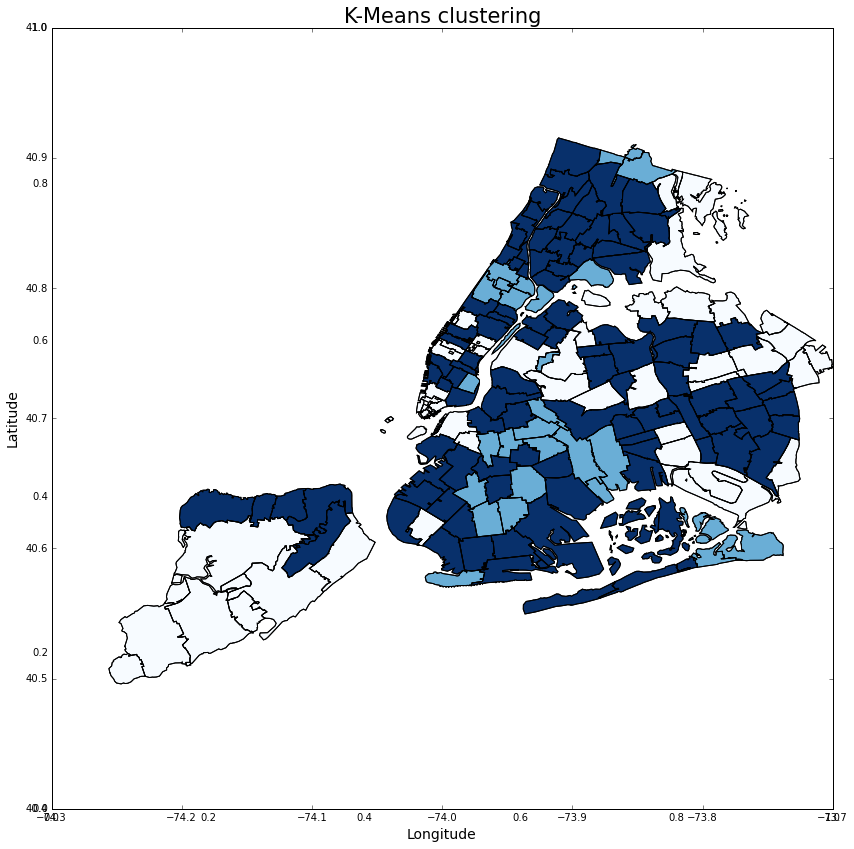

In [63]:
#est = k_means(ed1,n_clusters=3)

f, ax = plt.subplots(1, figsize=(14,14))
with_zip_plotting.plot(column='cluster', scheme='QUANTILES', alpha=1, colormap='Blues')
#Taking colorblind palette into consideration
plt.title('K-Means clustering', fontsize = 21)
plt.xlabel('Longitude', fontsize =14)
plt.ylabel('Latitude', fontsize = 14)


Discussion :
1. The weakness of the model is that it takes into consideration 5 data points. In such a case, stablity and variance tradeoff will not take a very great difference. This is because the training dataset itself is so less and make the decision more difficult. i.e. the model will be very specific to the training dataset 
2. The model due to lesser regressors has lower R. 
3. The clustering shows that the Staten Island are grouped together, bronx and upper manhattan are grouped together. So are random zipcodes withing brooklyn and queens. For queens mostly the areas near water are clustered consistenly together.
4. From the top 5 faclities that we have clustered, are actually in the bronx and upper manhattan zipcodes showing that they have highest cases. Infact even on increasing the number of cluster in K-means, the bronx group are unclustered. While with low cluster number, we see that areas near water are clustered together and less clustered when increasing the cluster number.  

